# 4.3 Refit best and transfer test on PTB dataset




## 1. Imports

In [1]:
import os
import sys
from pathlib import Path
import warnings
from typing import Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb

# Show working directory
print(os.getcwd())

# Ensure `src` is importable when running from the notebook
sys.path.append(str((Path.cwd() / "src").resolve()))

# Custom utilities
from src.utils.preprocessing import (
    load_processed_dataset,
    build_full_suffix as pp_build_full_suffix,
    generate_all_processed_datasets,
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

/home/christianm/Projects/Repos/heartbeat_classification


## 2. Refit best Model from part 4

In [2]:
params = {"classifier__colsample_bytree": 0.9, "classifier__gamma": 0.0,
               "classifier__learning_rate": 0.2, "classifier__max_depth": 9,
               "classifier__min_child_weight": 5, "classifier__n_estimators": 250,
               "classifier__reg_alpha": 0.2, "classifier__reg_lambda": 0.05,
               "classifier__subsample": 0.7}

# Preprocessed data sampling (loader) vs. model-time sampler
DATA_DIR = "data/processed/mitbih"
sampling_method = "No_Sampling"   # dataset loader suffix
model_sampler = "SMOTE"           # sampler applied inside the pipeline

model_name = "XGBoost"
remove_outliers = False

### XGBoost, SMOTE, no outlier removal,	no feature engineering

### Model Results

- **Accuracy**: 0.9834  
- **F1-Macro**: 0.9148  
- **CV-Score**: 0.9134  

### Per-class F1

| Class | F1 |
|---|---|
| 1 | 0.99 |
| 2 | 0.83 |
| 3 | 0.96 |
| 4 | 0.81 |
| 5 | 0.99 |

### Best Parameters

```json
{
  "classifier__colsample_bytree": 0.9,
  "classifier__gamma": 0.0,
  "classifier__learning_rate": 0.2,
  "classifier__max_depth": 9,
  "classifier__min_child_weight": 5,
  "classifier__n_estimators": 250,
  "classifier__reg_alpha": 0.2,
  "classifier__reg_lambda": 0.05,
  "classifier__subsample": 0.7
}
```


In [3]:
def prepare_dataset_with_sampling(
    data_dir: str = DATA_DIR,
    sampling_method: str = "No_Sampling",
    remove_outliers: bool = False
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    """Load an existing processed dataset for the given configuration.

    Datasets are assumed to be pre-generated by preprocessing utilities. This
    function never overwrites or generates new data; it only loads.
    """
    # Ensure all datasets are generated once (no-op if already done)
    generate_all_processed_datasets(data_dir=data_dir, only_once=True)

    full_suffix = pp_build_full_suffix(sampling_method, remove_outliers)
    split = load_processed_dataset(data_dir=data_dir, sampling_suffix=full_suffix)

    X_train_res = split.X_train.values
    y_train_res = split.y_train.values
    X_val = split.X_val.values if split.X_val is not None else None
    y_val = split.y_val.values if split.y_val is not None else None

    return X_train_res, X_val, y_train_res, y_val



print(f"\n{'='*80}")
print(f"Refitting {model_name} with best parameters and transferring to PTB (5-class as-is)")
print(f"Data sampling (loader): {sampling_method} | Model sampler: {model_sampler} | Outlier removal: {remove_outliers}")
print(f"{'='*80}")

# 1) Train multi-class on MIT-BIH (as-is, 5 classes)
X_train, X_val, y_train, y_val = prepare_dataset_with_sampling(
    sampling_method=sampling_method,
    remove_outliers=remove_outliers
)

best_params_clean = {k.replace("classifier__", ""): v for k, v in params.items()}
estimator = Pipeline([
    ("sampler", SMOTE(random_state=42)),
    ("classifier", xgb.XGBClassifier(
        **best_params_clean,
        objective="multi:softprob",
        num_class=5,
        n_jobs=-1,
        random_state=42,
        eval_metric="mlogloss",
    )),
])

# Fit once
estimator.fit(X_train, y_train)

# Evaluate on MIT validation set first
y_pred_mit = estimator.predict(X_val)
mit_accuracy = accuracy_score(y_val, y_pred_mit)
mit_precision_macro, mit_recall_macro, mit_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_pred_mit, average='macro', zero_division=0
)
mit_labels = np.unique(np.concatenate([y_train, y_val]))
mit_precision_per_class, mit_recall_per_class, mit_f1_per_class, _ = precision_recall_fscore_support(
    y_val, y_pred_mit, average=None, labels=mit_labels, zero_division=0
)
mit_confusion = confusion_matrix(y_val, y_pred_mit, labels=mit_labels)

print(f"\nMIT-BIH Validation Metrics:")
print(f"Accuracy: {mit_accuracy:.4f}")
print(f"F1-Macro: {mit_f1_macro:.4f}")
print(f"Precision-Macro: {mit_precision_macro:.4f}")
print(f"Recall-Macro: {mit_recall_macro:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip(mit_labels, mit_f1_per_class):
    print(f"  Class {int(lbl)}: {f1:.4f}")
print(f"\nMIT-BIH Confusion Matrix (rows=true, cols=pred):\n{mit_confusion}")



Refitting XGBoost with best parameters and transferring to PTB (5-class as-is)
Data sampling (loader): No_Sampling | Model sampler: SMOTE | Outlier removal: False
Loading processed X_train dataset from: data/processed/mitbih/X_train.csv
Loading processed y_train dataset from: data/processed/mitbih/y_train.csv

MIT-BIH Validation Metrics:
Accuracy: 0.9834
F1-Macro: 0.9148
Precision-Macro: 0.9190
Recall-Macro: 0.9110

Per-class F1 scores:
  Class 0: 0.9913
  Class 1: 0.8328
  Class 2: 0.9580
  Class 3: 0.8062
  Class 4: 0.9860

MIT-BIH Confusion Matrix (rows=true, cols=pred):
[[14385    58    25    16    10]
 [   79   361     4     0     1]
 [   37     2  1106     9     4]
 [   12     0    12   104     0]
 [   15     1     4     1  1265]]



Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)


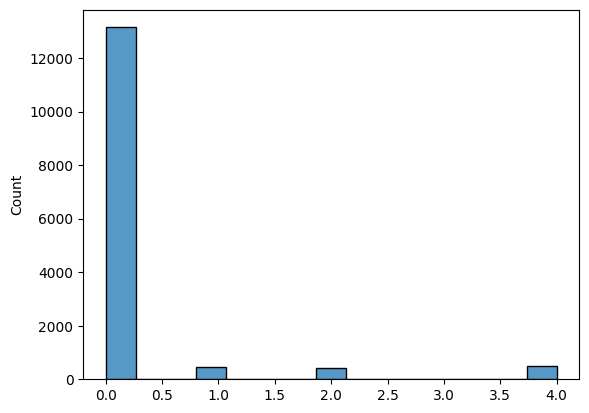

PTB (full) predicted 5-class distribution: {0: 13150, 1: 449, 2: 430, 3: 13, 4: 503}
PTB (full) true binary distribution: {0: 4045, 1: 10500}
PTB (full, mapped) Accuracy: 0.3488
PTB (full, mapped) F1-Macro: 0.3265
PTB (full, mapped) Confusion Matrix (rows=true, cols=pred):
 [[3862  183]
 [9288 1212]]


In [4]:
# Evaluate the fitted MIT-trained XGBoost on the entire PTB dataset (train + val)
from src.utils.preprocessing import prepare_ptbdb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

print("\n" + "="*80)
print("Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)")
print("="*80)

# Load PTB split (both train and validation)
ptb_split_full = prepare_ptbdb(data_dir="data/original", random_state=42)
X_ptb_full = np.vstack([ptb_split_full.X_train.values, ptb_split_full.X_val.values])
y_ptb_full = np.concatenate([ptb_split_full.y_train.values, ptb_split_full.y_val.values])

# Predict probabilities for 5 classes and map to binary (0 -> 0, 1/2/3/4 -> 1)
ptb_proba_5_full = estimator.predict_proba(X_ptb_full)
y_pred_ptb_5_full = np.argmax(ptb_proba_5_full, axis=1)

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(y_pred_ptb_5_full)
plt.show()

y_pred_ptb_bin_full = (y_pred_ptb_5_full != 0).astype(int)

# Metrics
acc_full = accuracy_score(y_ptb_full, y_pred_ptb_bin_full)
prec_macro_full, rec_macro_full, f1_macro_full, _ = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average="macro", zero_division=0
)
cm_full = confusion_matrix(y_ptb_full, y_pred_ptb_bin_full, labels=[0, 1])

# Distributions
unique_full, counts_full = np.unique(y_pred_ptb_5_full, return_counts=True)
pred_dist = {int(k): int(v) for k, v in zip(unique_full.tolist(), counts_full.tolist())}
true_dist = {int(k): int(v) for k, v in zip(*np.unique(y_ptb_full, return_counts=True))}

print("PTB (full) predicted 5-class distribution:", pred_dist)
print("PTB (full) true binary distribution:", true_dist)
print(f"PTB (full, mapped) Accuracy: {acc_full:.4f}")
print(f"PTB (full, mapped) F1-Macro: {f1_macro_full:.4f}")
print("PTB (full, mapped) Confusion Matrix (rows=true, cols=pred):\n", cm_full)


In [5]:
print("\n" + "="*80)
print("Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)")
print("="*80)

# Load PTB split (both train and validation)
ptb_split_full = prepare_ptbdb(data_dir="data/original", random_state=42)
X_ptb_full = np.vstack([ptb_split_full.X_train.values, ptb_split_full.X_val.values])
y_ptb_full = np.concatenate([ptb_split_full.y_train.values, ptb_split_full.y_val.values])

# Predict probabilities for 5 classes and map to binary (0 -> 0, 1/2/3/4 -> 1)
ptb_proba_5_full = estimator.predict_proba(X_ptb_full)
y_pred_ptb_5_full = np.argmax(ptb_proba_5_full, axis=1)
y_pred_ptb_bin_full = (y_pred_ptb_5_full != 0).astype(int)

# Metrics
acc_full = accuracy_score(y_ptb_full, y_pred_ptb_bin_full)
prec_macro_full, rec_macro_full, f1_macro_full, _ = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average="macro", zero_division=0
)
cm_full = confusion_matrix(y_ptb_full, y_pred_ptb_bin_full, labels=[0, 1])

# Distributions
unique_full, counts_full = np.unique(y_pred_ptb_5_full, return_counts=True)
pred_dist = {int(k): int(v) for k, v in zip(unique_full.tolist(), counts_full.tolist())}
true_dist = {int(k): int(v) for k, v in zip(*np.unique(y_ptb_full, return_counts=True))}

print("PTB (full) predicted 5-class distribution:", pred_dist)
print("PTB (full) true binary distribution:", true_dist)
print(f"PTB (full, mapped) Accuracy: {acc_full:.4f}")
print(f"PTB (full, mapped) F1-Macro: {f1_macro_full:.4f}")
print("PTB (full, mapped) Confusion Matrix (rows=true, cols=pred):\n", cm_full)


Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)
PTB (full) predicted 5-class distribution: {0: 13150, 1: 449, 2: 430, 3: 13, 4: 503}
PTB (full) true binary distribution: {0: 4045, 1: 10500}
PTB (full, mapped) Accuracy: 0.3488
PTB (full, mapped) F1-Macro: 0.3265
PTB (full, mapped) Confusion Matrix (rows=true, cols=pred):
 [[3862  183]
 [9288 1212]]


In [ ]:
# Refit XGBoost on PTB (binary) with SMOTE using the same params, then evaluate on PTB full
print("\n" + "="*80)
print("Refitting XGBoost with best parameters and evaluating on PTB (binary)")
print(f"Sampling: SMOTE | Outlier removal: {False}")
print("="*80)

# 1) Prepare PTB split (binary)
ptb_split = prepare_ptbdb(data_dir="data/original", random_state=42)
X_train_ptb = ptb_split.X_train.values
y_train_ptb = ptb_split.y_train.values.astype(int)
X_val_ptb = ptb_split.X_val.values
y_val_ptb = ptb_split.y_val.values.astype(int)

# Build "full" PTB set = train + val from the same split
X_ptb_full = np.vstack([ptb_split.X_train.values, ptb_split.X_val.values])
y_ptb_full = np.concatenate([ptb_split.y_train.values.astype(int), ptb_split.y_val.values.astype(int)])

# 2) Clean params from GridSearchCV (strip 'classifier__' prefix)
best_params_clean_ptb = {k.replace("classifier__", ""): v for k, v in params.items()}

print(f"Best Params: {best_params_clean_ptb}")

# 3) Build pipeline: SMOTE (train only) + XGBClassifier (binary)
pipe_ptb = Pipeline([
    ("sampler", SMOTE(random_state=42)),
    ("classifier", xgb.XGBClassifier(
        **best_params_clean_ptb,
        objective="binary:logistic",
        n_jobs=-1,
        random_state=42,
        eval_metric="logloss",
    )),
])

# 4) Fit on PTB train
pipe_ptb.fit(X_train_ptb, y_train_ptb)

# 5) Evaluate on PTB full (binary)
# Option A: use direct class predictions
y_pred_val = pipe_ptb.predict(X_val_ptb).astype(int)

# Option B (equivalent): threshold positive-class probability at 0.5
# proba_full = pipe_ptb.predict_proba(X_ptb_full)[:, 1]
# y_pred_ptb_full = (proba_full >= 0.5).astype(int)

# Metrics
acc_full = accuracy_score(y_val_ptb, y_pred_val)
prec_macro_full, rec_macro_full, f1_macro_full, _ = precision_recall_fscore_support(
    y_val_ptb, y_pred_val, average="macro", zero_division=0
)
cm_full = confusion_matrix(y_val_ptb, y_pred_val, labels=[0, 1])

# Distributions
pred_labels, pred_counts = np.unique(y_pred_val, return_counts=True)
true_labels, true_counts = np.unique(y_ptb_full, return_counts=True)
pred_dist = dict(zip(pred_labels.tolist(), pred_counts.tolist()))
true_dist = dict(zip(true_labels.tolist(), true_counts.tolist()))

print("PTB (full) predicted binary distribution:", pred_dist)
print("PTB (full) true binary distribution:", true_dist)
print(f"PTB (full) Accuracy: {acc_full:.4f}")
print(f"PTB (full) F1-Macro: {f1_macro_full:.4f}")
print("PTB (full) Confusion Matrix (rows=true, cols=pred):\n", cm_full)


Refitting XGBoost with best parameters and evaluating on PTB (binary)
Sampling: SMOTE | Outlier removal: False
Best Params: {'colsample_bytree': 0.9, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 250, 'reg_alpha': 0.2, 'reg_lambda': 0.05, 'subsample': 0.7}
PTB (full) predicted binary distribution: {0: 808, 1: 2101}
PTB (full) true binary distribution: {0: 4045, 1: 10500}
PTB (full) Accuracy: 0.9777
PTB (full) F1-Macro: 0.9722
PTB (full) Confusion Matrix (rows=true, cols=pred):
 [[ 776   33]
 [  32 2068]]


In [7]:
# Evaluate PTB-trained binary model on MIT dataset
print("\n" + "="*80)
print("Transfer Learning: Evaluating PTB-trained binary XGBoost on MIT-BIH dataset")
print("="*80)

# Use MIT validation set (already loaded from previous cells)
# X_val and y_val are from MIT-BIH

# Get binary predictions from PTB model on MIT data
y_pred_mit_binary = pipe_ptb.predict(X_val)

# ============================================================================
# Evaluation 1: Multi-class abnormal mapping
# Map MIT classes: 0→0 (normal), {1,2,3,4}→1 (all abnormal)
# ============================================================================
print("\n" + "-"*80)
print("Evaluation 1: All abnormal classes (1-4) mapped to binary class 1")
print("-"*80)

y_true_mit_multi_binary = (y_val != 0).astype(int)  # 0 stays 0, all others become 1

acc_1 = accuracy_score(y_true_mit_multi_binary, y_pred_mit_binary)
prec_macro_1, rec_macro_1, f1_macro_1, _ = precision_recall_fscore_support(
    y_true_mit_multi_binary, y_pred_mit_binary, average="macro", zero_division=0
)
prec_per_class_1, rec_per_class_1, f1_per_class_1, _ = precision_recall_fscore_support(
    y_true_mit_multi_binary, y_pred_mit_binary, average=None, labels=[0, 1], zero_division=0
)
cm_1 = confusion_matrix(y_true_mit_multi_binary, y_pred_mit_binary, labels=[0, 1])

# Distribution info
true_dist_multi = {int(k): int(v) for k, v in zip(*np.unique(y_true_mit_multi_binary, return_counts=True))}
pred_dist_multi = {int(k): int(v) for k, v in zip(*np.unique(y_pred_mit_binary, return_counts=True))}

print(f"\nMIT true binary distribution (all abnormal): {true_dist_multi}")
print(f"PTB model predictions distribution: {pred_dist_multi}")
print(f"\nAccuracy: {acc_1:.4f}")
print(f"F1-Macro: {f1_macro_1:.4f}")
print(f"Precision-Macro: {prec_macro_1:.4f}")
print(f"Recall-Macro: {rec_macro_1:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip([0, 1], f1_per_class_1):
    class_name = "Normal" if lbl == 0 else "Abnormal (all 1-4)"
    print(f"  Class {lbl} ({class_name}): {f1:.4f}")
print(f"\nConfusion Matrix (rows=true, cols=pred):\n{cm_1}")

# ============================================================================
# Evaluation 2: Single-class abnormal mapping
# Map MIT classes: 0→0 (normal), 1→1 (abnormal), drop classes {2,3,4}
# ============================================================================
print("\n" + "-"*80)
print("Evaluation 2: Only class 1 mapped to binary class 1 (classes 2,3,4 dropped)")
print("-"*80)

# Create mask: keep only MIT classes 0 and 1
keep_mask = (y_val == 0) | (y_val == 1)
y_val_filtered = y_val[keep_mask]
X_val_filtered = X_val[keep_mask]
y_pred_mit_binary_filtered = pipe_ptb.predict(X_val_filtered)

# Map to binary: 0→0, 1→1 (already binary since we filtered)
y_true_mit_single_binary = y_val_filtered.astype(int)

acc_2 = accuracy_score(y_true_mit_single_binary, y_pred_mit_binary_filtered)
prec_macro_2, rec_macro_2, f1_macro_2, _ = precision_recall_fscore_support(
    y_true_mit_single_binary, y_pred_mit_binary_filtered, average="macro", zero_division=0
)
prec_per_class_2, rec_per_class_2, f1_per_class_2, _ = precision_recall_fscore_support(
    y_true_mit_single_binary, y_pred_mit_binary_filtered, average=None, labels=[0, 1], zero_division=0
)
cm_2 = confusion_matrix(y_true_mit_single_binary, y_pred_mit_binary_filtered, labels=[0, 1])

# Distribution info
true_dist_single = {int(k): int(v) for k, v in zip(*np.unique(y_true_mit_single_binary, return_counts=True))}
pred_dist_single = {int(k): int(v) for k, v in zip(*np.unique(y_pred_mit_binary_filtered, return_counts=True))}
dropped_count = len(y_val) - len(y_val_filtered)

print(f"\nMIT samples: {len(y_val)} total, {dropped_count} dropped (classes 2,3,4), {len(y_val_filtered)} kept")
print(f"MIT true binary distribution (class 1 only): {true_dist_single}")
print(f"PTB model predictions distribution: {pred_dist_single}")
print(f"\nAccuracy: {acc_2:.4f}")
print(f"F1-Macro: {f1_macro_2:.4f}")
print(f"Precision-Macro: {prec_macro_2:.4f}")
print(f"Recall-Macro: {rec_macro_2:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip([0, 1], f1_per_class_2):
    class_name = "Normal" if lbl == 0 else "Abnormal (class 1 only)"
    print(f"  Class {lbl} ({class_name}): {f1:.4f}")
print(f"\nConfusion Matrix (rows=true, cols=pred):\n{cm_2}")


Transfer Learning: Evaluating PTB-trained binary XGBoost on MIT-BIH dataset

--------------------------------------------------------------------------------
Evaluation 1: All abnormal classes (1-4) mapped to binary class 1
--------------------------------------------------------------------------------

MIT true binary distribution (all abnormal): {0: 14494, 1: 3017}
PTB model predictions distribution: {0: 2186, 1: 15325}

Accuracy: 0.2850
F1-Macro: 0.2834
Precision-Macro: 0.5707
Recall-Macro: 0.5542

Per-class F1 scores:
  Class 0 (Normal): 0.2494
  Class 1 (Abnormal (all 1-4)): 0.3174

Confusion Matrix (rows=true, cols=pred):
[[ 2080 12414]
 [  106  2911]]

--------------------------------------------------------------------------------
Evaluation 2: Only class 1 mapped to binary class 1 (classes 2,3,4 dropped)
--------------------------------------------------------------------------------

MIT samples: 17511 total, 2572 dropped (classes 2,3,4), 14939 kept
MIT true binary distribu